In [1]:
# %%
# Necessary imports
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# %%
# Setting plot style for better visualization
sns.set_theme(style="whitegrid")

# Directory containing CSV files
data_directory = 'data_Q1_2017'

# Function to load and concatenate datasets
def load_and_concatenate(directory):
    df_list = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):  # Make sure to load only CSV files
            file_path = os.path.join(directory, filename)
            current_df = pd.read_csv(file_path)
            df_list.append(current_df)
    full_df = pd.concat(df_list, ignore_index=True)
    return full_df

# %%
# Loading dataset
df = load_and_concatenate(data_directory)

C:\Users\Priyanshu\AppData\Local\Temp\ipykernel_18348\955917026.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(df_list, ignore_index=True)


In [3]:
# %%
# Preprocessing the DataFrame (dropping all-null columns, filtering failed HDDs)
df = df.loc[:, ~df.isnull().all()]
failed_hdds = df.loc[df.failure == 1]["serial_number"]
df = df.loc[df["serial_number"].isin(failed_hdds)]

# %%
# Calculating Remaining Useful Life (RUL)
df["end_date"] = df.groupby("serial_number")["date"].transform("max")
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])
df["date_diff"] = (df["end_date"] - df["date"]).dt.days


In [4]:

# %%
# Define the prediction horizon (in days)
prediction_horizon = 15

# Create the binary labels based on the prediction horizon
df['will_fail'] = (df['date_diff'] <= prediction_horizon).astype(int)

# %%
# Drop unnecessary columns
df = df.drop(['date', 'serial_number', 'model', 'end_date', 'date_diff'], axis=1)

# %%
# Split the data into features and target
X = df.drop("will_fail", axis=1)
y = df["will_fail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# %%
# Train a Random Forest Classifier
RF_classifier = RandomForestClassifier(random_state=1)
RF_classifier.fit(X_train, y_train)

# %%
# Evaluate the classifier
y_pred = RF_classifier.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

# %%
# Predict the probability of failure within the prediction horizon for the test set
probabilities = RF_classifier.predict_proba(X_test)[:, 1]


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2294
           1       0.97      0.95      0.96      1067

    accuracy                           0.98      3361
   macro avg       0.97      0.97      0.97      3361
weighted avg       0.98      0.98      0.98      3361

Confusion Matrix:
 [[2261   33]
 [  49 1018]]
AUC-ROC: 0.9698457489445185


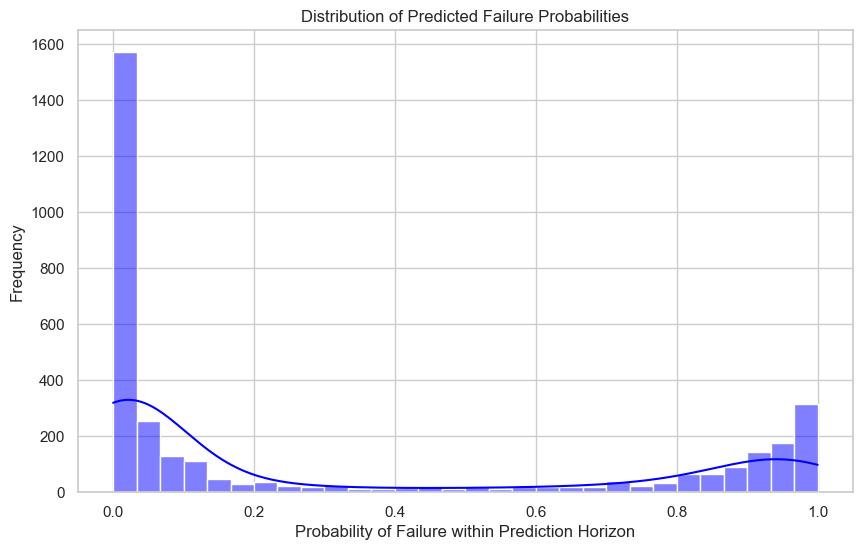

In [6]:

# %%
# Visualize the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(probabilities, kde=True, bins=30, color="blue")
plt.title("Distribution of Predicted Failure Probabilities")
plt.xlabel("Probability of Failure within Prediction Horizon")
plt.ylabel("Frequency")
plt.show()

In [7]:




# %%
# Flag HDDs for maintenance based on a defined probability threshold
threshold = 0.5  # Example threshold for classification
predictions = (probabilities >= threshold).astype(int)
flagged_hdds = np.where(predictions == 1)[0]
print("Flagged HDDs for maintenance:", flagged_hdds)


Flagged HDDs for maintenance: [   4    7   13 ... 3352 3354 3358]
